In [506]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from os import listdir
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, TSNE, MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.utils import check_random_state
import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer

In [ ]:
def cluster_stability(X, est, n_iter=20, random_state=None):
    labels = []
    indices = []
    for i in range(n_iter):
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        est = clone(est)
        if hasattr(est, "random_state"):
            est.random_state = rng.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        relabel = -np.ones(X.shape[0], dtype=np.int32)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

In [ ]:
X_rnd = np.random.random(X.shape)

In [190]:
emotion_scales_path = '/Users/giovanni/Documents/Datasets/LEMON/Behavioural_Data_MPILMBB_LEMON/Emotion_and_Personality_Test_Battery_LEMON/'
scale_names = [s.split('.')[0] for s in listdir(emotion_scales_path) if s.split('.')[1] == 'csv']
emotion_scales = {}

for sn in scale_names:
    scale_path = emotion_scales_path+sn+'.csv'
    s = pd.read_csv(scale_path)
    emotion_scales[sn]=s

In [191]:
scale = emotion_scales['TICS']
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})

scale_df = scale


scale = emotion_scales['PSQ']
scale = scale.replace(' ', np.nan)
scale = scale.dropna()
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})
scale = scale.astype({'PSQ_Worries': 'float', 'PSQ_Tension': 'float', 'PSQ_Joy': 'float', 'PSQ_Demands': 'float', 'PSQ_OverallScore': 'float'})

scale_df = scale_df.merge(scale, on='sbj_id', how='left')


scale = emotion_scales['STAI_G_X2']
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})

scale_df = scale_df.merge(scale, on='sbj_id', how='left').dropna()


z_question = zscore(scale_df[scale_df.columns[1:]].values, axis=0)
pca = PCA(n_components=3)
pca_question = pca.fit_transform(z_question)

scale_df['q_pca_1'] = pca_question[:,0]
scale_df['q_pca_2'] = pca_question[:,1]
scale_df['q_pca_3'] = pca_question[:,2]

scale_cols = scale_df.columns[1:]

In [192]:
subject_meta_path = '/Users/giovanni/Documents/Datasets/LEMON/Behavioural_Data_MPILMBB_LEMON/META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv'
subject_meta_df = pd.read_csv(subject_meta_path)
subject_meta_df = subject_meta_df.rename(columns={'Unnamed: 0':'sbj_id'})
subject_meta_df = subject_meta_df.rename(columns={'Gender_ 1=female_2=male':'gender'})
subject_meta_df['gender'] = subject_meta_df['gender'] -1 
subject_meta_df['Standard_Alcoholunits_Last_28days'] = subject_meta_df['Standard_Alcoholunits_Last_28days'].fillna('-1').apply(lambda x: x.replace(',','.')).astype(float)

for colname in subject_meta_df.columns:
    if (subject_meta_df.dtypes == 'object')[colname] == False:
        continue
    col = subject_meta_df[colname]
    code_dict = {k:v for v,k in enumerate(col.unique())}
    code_col = pd.DataFrame({colname+'_coded':[code_dict[c] for c in col]})
    subject_meta_df = subject_meta_df.join(code_col)

subject_meta_df['Age_num'] = subject_meta_df['Age'].apply(lambda x: np.mean(list(map(int, x.split('-')))))
subject_meta_df['Smoking_coded_bin'] = (subject_meta_df['Smoking_num_(Non-smoker=1, Occasional Smoker=2, Smoker=3)'] > 1).astype(int)

In [193]:
processed_data_path = '/Users/giovanni/Documents/Datasets/LEMON/processed/'
hrv_df = pd.read_json(processed_data_path+'LEMON_ppg_features.json')
hrv_df = hrv_df.rename(columns={'sd1/sd2':'sd1_sd2'})
hrv_df = hrv_df.groupby('sbj_id').mean().reset_index()

In [194]:
processed_data_path = '/Users/giovanni/Documents/Datasets/LEMON/processed/'

fmri_df = pd.read_json(processed_data_path+'LEMON_fmri_rs_features_DMN_complete.json')[:]
fmri_df['DMN_amp_mean_PPC_LTJ'] = fmri_df[['DMN_amp_mean_PCC', 'DMN_amp_mean_LTJ']].mean(1)

In [231]:
hp_test_df.columns

Index(['DMN_cor_mean', 'DMN_cor_std', 'DMN_cor_PCC_LTJ', 'DMN_cor_PCC_RTJ',
       'DMN_cor_PCC_MPC', 'DMN_cor_LTJ_RTJ', 'DMN_cor_LTJ_MPC',
       'DMN_cor_RTJ_MPC', 'DMN_par_mean', 'DMN_par_std', 'DMN_par_PCC_LTJ',
       'DMN_par_PCC_RTJ', 'DMN_par_PCC_MPC', 'DMN_par_LTJ_RTJ',
       'DMN_par_LTJ_MPC', 'DMN_par_RTJ_MPC', 'DMN_amp_tot_mean',
       'DMN_amp_tot_std', 'DMN_amp_mean_PCC', 'DMN_amp_mean_LTJ',
       'DMN_amp_mean_RTJ', 'DMN_amp_mean_MPC', 'DMN_amp_max_PCC',
       'DMN_amp_max_LTJ', 'DMN_amp_max_RTJ', 'DMN_amp_max_MPC', 'sbj_id',
       'DMN_amp_mean_PPC_LTJ', 'ses_id', 'run_id', 'peak_rej_rate',
       'hrv_rej_rate', 'bpm', 'ibi', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2',
       's', 'sd1_sd2', 'breathingrate', 'sdnn_hr', 'sdsd_hr', 'rmssd_hr',
       'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',


In [403]:
hp_test_df = fmri_df.merge(hrv_df, on='sbj_id', how='left').dropna()

hp_test_df = hp_test_df.merge(subject_meta_df[['sbj_id',
                                               'gender', 
                                               'Age_num',
                                               'Smoking_coded_bin']], on='sbj_id', how='left').dropna()

hp_test_df = hp_test_df.merge(scale_df, on='sbj_id', how='left').dropna()


In [426]:
col_selection = ['DMN_amp_mean_PCC', 'DMN_amp_mean_LTJ', 'sd1_sd2', 'Age_num', 'gender']
exp_df = hp_test_df[col_selection]
exp_df = exp_df.apply(zscore, axis=0)
X = exp_df.values

In [481]:
### this should be collapsed into one function


n_cl = np.arange(2, 20).astype(int)
stb = []

for n_clusters in n_cl:
    km = AgglomerativeClustering(n_clusters=n_clusters)
    km.fit(X)
    stability = cluster_stability(X, AgglomerativeClustering(n_clusters=n_clusters), n_iter=20)
    stb.append(stability)



n_cl = np.arange(2, 20).astype(int)
rnd_stb = []

for n_clusters in n_cl:
    km = AgglomerativeClustering(n_clusters=n_clusters)
    km.fit(X_rnd)
    stability = cluster_stability(X_rnd, AgglomerativeClustering(n_clusters=n_clusters), n_iter=20)
    rnd_stb.append(stability)

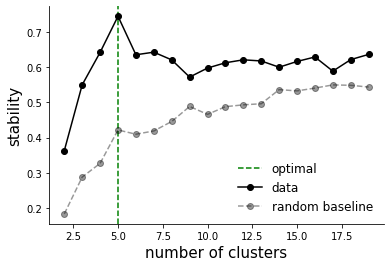

In [504]:
plt.axvline(5, c='g', ls='--', label='optimal')
plt.plot(n_cl, stb, 'ko-', label='data')
plt.plot(n_cl, rnd_stb, 'ko--', alpha=.4, label='random baseline')


plt.legend(loc=4, frameon=False, fontsize=12)
plt.xlabel('number of clusters', fontsize=15)
plt.ylabel('stability', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

### Running clustering with optimal 

In [432]:
clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(X)
hp_test_df['cluster_lbl'] = pd.DataFrame({'cluster_lbl': clustering.labels_})

embedding = MDS(n_components=3) # 3
X_ld = embedding.fit_transform(X)

AgglomerativeClustering(n_clusters=5)

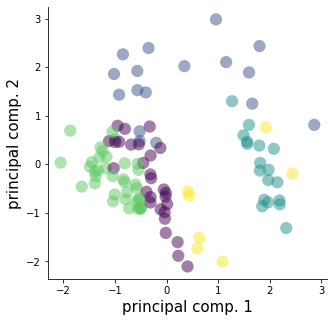

In [462]:
plt.figure(figsize=(5,5))
plt.scatter(X_ld[:,0], X_ld[:,1], c=clustering.labels_, alpha=.5, s=150, lw=0)
plt.xlabel('principal comp. 1', fontsize=15)
plt.ylabel('principal comp. 2', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [509]:
model_formula = 'STAI_Trait_Anxiety ~ C(cluster_lbl)'
results_stai = smf.ols(model_formula, data=hp_test_df).fit()
results_stai.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     STAI_Trait_Anxiety   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.366
Date:                Fri, 22 Apr 2022   Prob (F-statistic):             0.0125
Time:                        14:02:46   Log-Likelihood:                -374.75
No. Observations:                 106   AIC:                             759.5
Df Residuals:                     101   BIC:                             772.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              41.6071      1.607     25.888      0.000      38.419      44.795
C(cluster_lbl)[T.1]    -8.6071      2.615     -3.292      0.001     -13.794      -3.420
C(cluster_lbl)[T.2]    -6.3294      2.569     -2.463      0.015     -11.426      -1.233
C(cluster_lbl)[T.3]    -5.0794      2.143     -2.370      0.020      -9.330      -0.828
C(cluster_lbl)[T.4]    -7.1786      3.594     -1.997      0.048     -14.308      -0.049
==============================================================================
Omnibus:                        6.988   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                3.426
Skew:                           0.183   Prob(JB):                        0.180
Kurtosis:                       2.199   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [510]:
model_formula = 'PSQ_OverallScore ~ C(cluster_lbl)'
results_psq = smf.ols(model_formula, data=hp_test_df).fit()
results_psq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PSQ_OverallScore   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     6.458
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           0.000114
Time:                        14:02:49   Log-Likelihood:                -430.31
No. Observations:                 106   AIC:                             870.6
Df Residuals:                     101   BIC:                             883.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              41.9643      2.714     15.459      0.000      36.579      47.349
C(cluster_lbl)[T.1]   -19.5133      4.416     -4.418      0.000     -28.274     -10.752
C(cluster_lbl)[T.2]    -9.4643      4.339     -2.181      0.032     -18.073      -0.856
C(cluster_lbl)[T.3]   -13.6310      3.619     -3.766      0.000     -20.811      -6.451
C(cluster_lbl)[T.4]   -18.8690      6.070     -3.109      0.002     -30.910      -6.828
==============================================================================
Omnibus:                        4.342   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.481
Skew:                           0.329   Prob(JB):                        0.175
Kurtosis:                       2.405   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [511]:
stargazer = Stargazer([results_stai, results_psq])
stargazer.covariate_order(['Intercept', 'C(cluster_lbl)[T.1]', 'C(cluster_lbl)[T.2]', 'C(cluster_lbl)[T.3]', 'C(cluster_lbl)[T.4]'])
stargazer.rename_covariates({
    'C(cluster_lbl)[T.1]': 'Cluster 1',
    'C(cluster_lbl)[T.2]': 'Cluster 2',
    'C(cluster_lbl)[T.3]': 'Cluster 3',
    'C(cluster_lbl)[T.4]': 'Cluster 4'
    })
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 41.607$^{***}$ & 41.964$^{***}$ \\
  & (1.607) & (2.714) \\
 Cluster 1 & -8.607$^{***}$ & -19.513$^{***}$ \\
  & (2.615) & (4.416) \\
 Cluster 2 & -6.329$^{**}$ & -9.464$^{**}$ \\
  & (2.569) & (4.339) \\
 Cluster 3 & -5.079$^{**}$ & -13.631$^{***}$ \\
  & (2.143) & (3.619) \\
 Cluster 4 & -7.179$^{**}$ & -18.869$^{***}$ \\
  & (3.594) & (6.070) \\
\hline \\[-1.8ex]
 Observations & 106 & 106 \\
 $R^2$ & 0.118 & 0.204 \\
 Adjusted $R^2$ & 0.083 & 0.172 \\
 Residual Std. Error & 8.504 & 14.364  \\
 F Statistic & 3.366$^{**}$  & 6.458$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


(array([ 2.,  7., 15., 21., 13., 14., 15., 10.,  7.,  2.]),
 array([-18.60714286, -14.74642857, -10.88571429,  -7.025     ,
         -3.16428571,   0.69642857,   4.55714286,   8.41785714,
         12.27857143,  16.13928571,  20.        ]),
 <BarContainer object of 10 artists>)

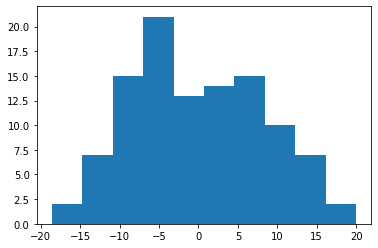

In [436]:
plt.hist(results.resid)


In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score
rng = np.random.RandomState(1)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

